In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Imports

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u1.base')...]

In [4]:
# main table is in the file u.data
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# dot product
last_skywalker = np.array([0.98,0.9,-0.9])
user1 = np.array([0.9,0.8,-0.6])

In [6]:
(user1*last_skywalker).sum()

2.1420000000000003

In [7]:
# we would rather see movie titles than their IDs
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()


,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
# merge this with our ratings table to get the user ratings by title
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [9]:
ratings.columns

Index(['user', 'movie', 'rating', 'timestamp', 'title'], dtype='object')

In [10]:
# building a DataLoaders object from this table
# By default, it takes the first column for the user, the second column for the item (here our movies), 
# and the third column for the ratings

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()


,user,title,rating
0,399,Spy Hard (1996),3
1,691,GoodFellas (1990),5
2,6,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",4
3,627,Murder in the First (1995),3
4,793,Grosse Pointe Blank (1997),4
5,862,"Maltese Falcon, The (1941)",4
6,531,Titanic (1997),5
7,316,Cape Fear (1962),2
8,158,"Godfather, The (1972)",5
9,87,Cool Hand Luke (1967),5


In [11]:
dls.classes.keys()

dict_keys(['user', 'title'])

In [12]:
# Creating latent factors
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
# represent look up in an index as a matrix product
# The trick is to replace our indices with one-hot-encoded vectors
one_hot_3 = one_hot(3, n_users).float()

In [14]:
user_factors.shape, one_hot_3.shape

(torch.Size([944, 5]), torch.Size([944]))

In [15]:
user_factors.t() @ one_hot_3

tensor([ 1.2699, -1.3159, -0.2296,  0.0196,  1.0273])

### Creating Embeddings

In [16]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [17]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [18]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

### Training over 5 epochs 

In [19]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.334954,1.272748,00:08
1,1.068752,1.063393,00:08
2,0.946590,0.956639,00:08
3,0.839978,0.872860,00:08
4,0.777246,0.856376,00:08


In [20]:
print(learn.model)
dot_products = []
user_weights = learn.model.user_factors.weight[:2,]
movie_factors = learn.model.movie_factors.weight[:2,]
res = []
for i in range(len(user_weights)):
    dot_products.append([])
    for j in range(len(movie_factors)):
        dot_products[i].append(user_weights[i]*movie_factors[j])
for sublist in dot_products:
    res.append(sum(sublist))

DotProduct(
  (user_factors): Embedding(944, 50)
  (movie_factors): Embedding(1665, 50)
)


In [21]:
res

[tensor([ 5.1672e-04,  2.0068e-05,  3.4430e-04, -1.7194e-03,  7.4037e-04,
         -5.6413e-04,  7.9791e-04,  4.9853e-05,  1.0914e-04,  9.7595e-04,
         -6.2422e-04,  3.7991e-05, -9.9492e-05,  1.9528e-04,  6.9068e-04,
          2.5971e-04, -3.4383e-04,  1.4763e-03, -4.8298e-04, -2.8924e-04,
         -4.2502e-04, -1.1714e-03,  1.2268e-03,  3.2226e-04, -7.5717e-04,
         -7.3091e-04, -1.1725e-03, -1.1934e-03, -1.2106e-03,  9.1333e-04,
          4.9074e-04, -1.3269e-03, -1.9125e-03,  1.4979e-04, -1.2587e-03,
         -4.3936e-04, -2.1375e-03, -5.7001e-05,  1.1128e-03,  4.7793e-04,
         -5.1979e-05,  7.6168e-04,  1.0045e-03,  1.9153e-03, -2.8841e-04,
         -1.7137e-03, -4.4149e-05, -7.6440e-04, -1.4920e-03, -1.5141e-04],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([ 0.0086,  0.0417,  0.0477,  0.0443,  0.0604,  0.0469,  0.0385,  0.0417,
          0.0029,  0.0548,  0.0547,  0.0476,  0.0478,  0.0510,  0.0371,  0.0360,
          0.0378,  0.0456,  0.0582,  0.0498,  0

In [22]:
# the result in previous cell contains values out of 0-5 range
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [23]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.978437,0.979983,00:08
1,0.882990,0.890270,00:08
2,0.701720,0.859069,00:08
3,0.472858,0.868377,00:11
4,0.363182,0.873599,00:11


In [24]:
# adding bias
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.946136,0.910396,00:12
1,0.838205,0.841341,00:13
2,0.615510,0.850021,00:12
3,0.420801,0.876278,00:13
4,0.299626,0.883141,00:12


### The Model is overfitting

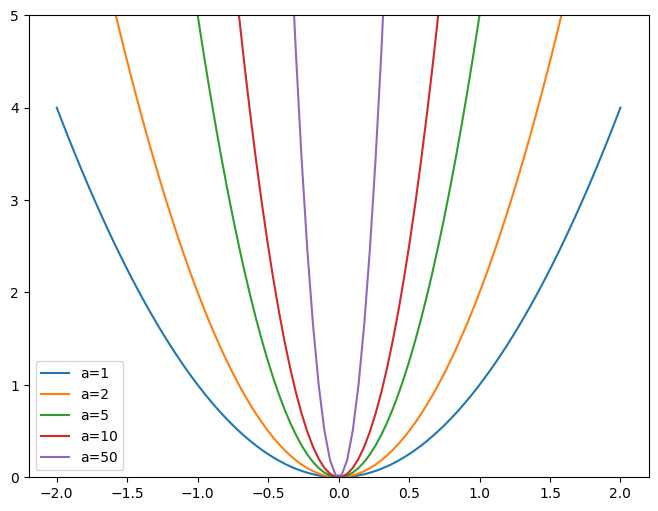

In [26]:
# adding weight decay to reduce overfitting
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();


In [27]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.960498,0.932158,00:14
1,0.844487,0.863502,00:13
2,0.726180,0.821379,00:13
3,0.592830,0.811296,00:13
4,0.487464,0.811891,00:13


### Creating Our Own Embedding Module

In [28]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [29]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.7765],
        [-0.7064],
        [ 0.8882]], requires_grad=True)]

In [30]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [31]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [32]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [33]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954548,0.929891,00:13
1,0.860919,0.860415,00:13
2,0.737474,0.818517,00:14
3,0.595837,0.807379,00:13
4,0.481768,0.808076,00:14


### Interpreting Embeddings and Biases

In [34]:
# movies with the lowest values in the bias vector
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]
    

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Big Bully (1996)',
 'Crow: City of Angels, The (1996)',
 'Jungle2Jungle (1997)']

The movie bias is a learned parameter that represents the tendency of users to rate movies higher or lower than their actual rating. By sorting the movie bias tensor in ascending order and selecting the first five indices, we get the movies with the lowest bias, which means that users tend to rate them lower than their actual rating even if they match well with the users' preferences.

This information is more interesting than simply sorting the movies by their average rating, as it indicates that users tend to have a consistent dislike towards certain movies regardless of their genre or other factors. Similarly, selecting the last five indices (highest bias) gives us the movies that users tend to rate higher than their actual rating, indicating a consistent liking towards those movies despite other factors.

In [45]:
# movies with the highest bias
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'Star Wars (1977)']

### Principal Component Analysis (PCA)

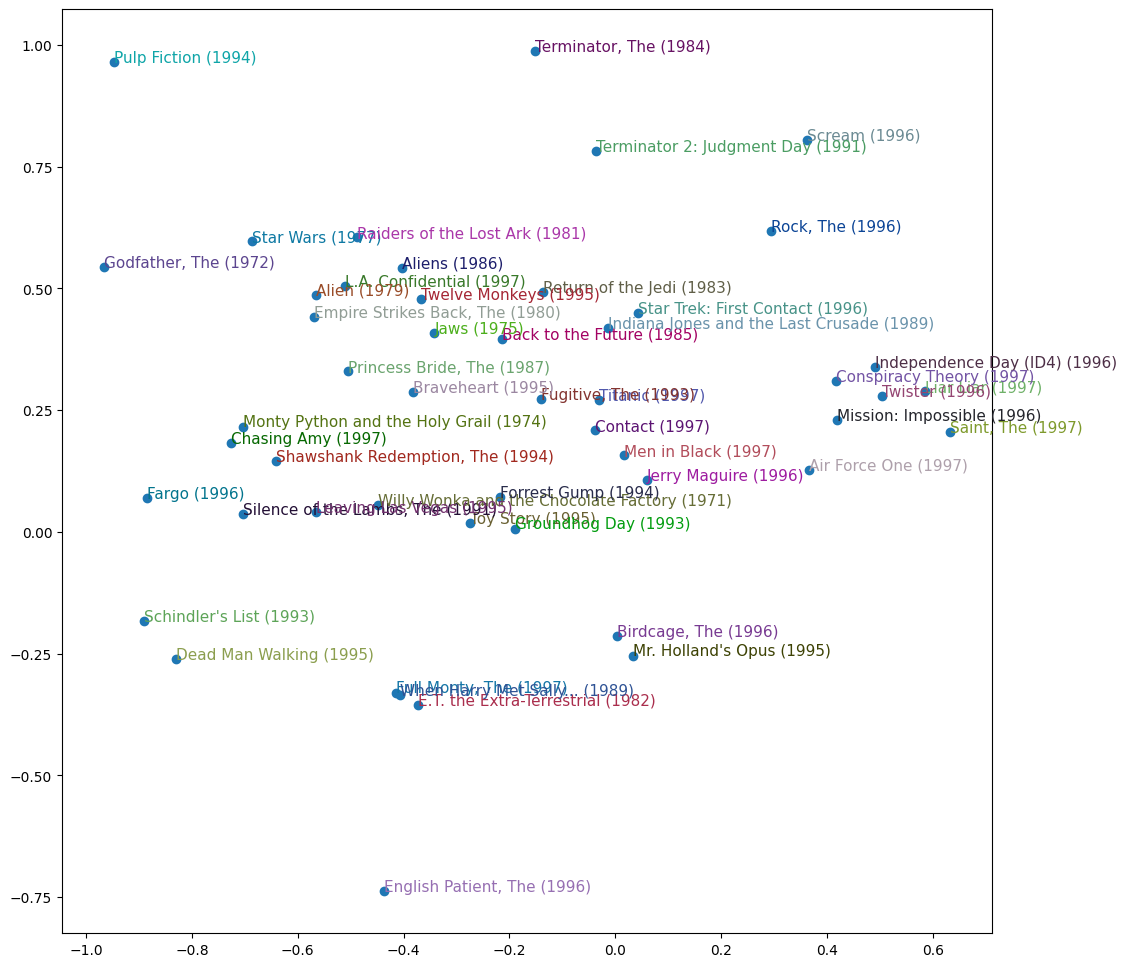

In [46]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()
     

### Embedding Distance

In [71]:
#  For a 50-dimensional embedding we can do exactly the same thing, except that we 
# add up the squares of all 50 of the coordinate distances.
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

"Schindler's List (1993)"